In [80]:
import copy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats 
import statsmodels.api as sm


warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 8

# Load and clean the data

In [2]:
data = pd.read_csv('./data.csv')
data.head(5)

,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100


In [3]:
data['time_stamp'] = data['date'].apply(lambda x: pd.Timestamp(x))

In [4]:
price = data.pivot(index='time_stamp', columns='ticker', values='last')
volume = data.pivot(index='time_stamp', columns='ticker', values='volume')

## Divide data into in-sample of out-of-sample dataset

In [5]:
time_point = pd.Timestamp('20181231')

price_in = price[price.index <= time_point]
volume_in = volume[volume.index <= time_point]

# Research

In [6]:
def rolling_z_score(raw_signal, window):
    mean_df = raw_signal.rolling(window).mean()
    std_df = raw_signal.rolling(window).std()
    return (raw_signal - mean_df) / std_df

In [7]:
def winsorize(signal, threshold):
    signal[signal>threshold] = threshold
    signal[signal<-threshold] = -threshold
    return signal 

## Test signals

In [8]:
Signals = {}

In [9]:
def calc_corr(x,y, nan_tolerance=0.5):
    min_length = len(x) * nan_tolerance
    valid_data = ~(np.isnan(x) | np.isnan(y))

    if sum(valid_data) < min_length:
        return np.nan
    else:
        return np.corrcoef(x[valid_data], y[valid_data])[0][1]


### Test for single signal

In [10]:
def calc_ic(signal, lag=1, price=price):
    signal = signal.reindex(price.index)
    ret = np.log(price).diff(1).shift(-lag)
    ic = pd.Series()
    rank_ic = pd.Series()

    for i, t in enumerate(signal.index):
        ic.loc[t] = calc_corr(signal.loc[t].values, ret.loc[t].values)
        rank_ic.loc[t] = stats.spearmanr(signal.loc[t].values, ret.loc[t].values, nan_policy='omit').statistic
    
    return ic, rank_ic

In [11]:
def adjust_subplot(ax, title=''):
    ax.grid()
    ax.legend(fontsize=8)
    ax.set_title(title, fontsize=10)

In [12]:
def calc_relation(signal, lag=1, num_layers=5, price=price):
    signal = signal.reindex(price.index)
    ret = np.log(price).diff(1).shift(-lag) * 100
    tmp = pd.concat([signal.stack(dropna=False), ret.stack(dropna=False)], axis=1)
    tmp.dropna(inplace=True)

    tmp.columns = ['signal', 'ret']
    
    key_points = [np.quantile(tmp['signal'], i/num_layers) for i in range(num_layers)] + [tmp['signal'].max()]
    ret_mean = []; ret_std = []
    for i in range(num_layers):
        tmp1 = tmp[(tmp['signal']>key_points[i]) & (tmp['signal']<=key_points[i+1])]
        ret_mean.append(np.mean(tmp1['ret'])); ret_std.append(np.std(tmp1['ret']) / np.sqrt(len(tmp1['ret'])))
    return ret_mean, ret_std

    

In [13]:
def calc_decay(signal, max_forward_looking, price=price):
    signal = signal.reindex(price.index)
    decay_long_mean = []; decay_long_std = []
    decay_short_mean = []; decay_short_std = []
    decay_ic = []
    for k in range(1, max_forward_looking+1):
        ret = np.log(price).diff(k).shift(-k) * 100
        tmp = pd.concat([signal.stack(dropna=False), ret.stack(dropna=False)], axis=1)
        tmp.dropna(inplace=True) 
        tmp.columns = ['signal', 'ret']   
        tmp_long = tmp[(tmp['signal']>0)]
        tmp_short = tmp[(tmp['signal']<0)]
        decay_long_mean.append(tmp_long['ret'].mean())
        decay_long_std.append(tmp_long['ret'].std() / np.sqrt(len(tmp_long['ret'])))
        decay_short_mean.append(tmp_short['ret'].mean())
        decay_short_std.append(tmp_short['ret'].std() / np.sqrt(len(tmp_short['ret'])))
   # for k in range(1, max_forward_looking+1):
   #     ic, rank_ic = calc_ic(signal, lag=k)
   #     decay_ic.append(np.mean(ic))
    return decay_long_mean, decay_short_mean, decay_long_std, decay_short_std#, decay_ic

In [14]:
def calc_turnover(signal, price=price):
    signal = signal.reindex(price.index)
    change = np.abs(signal.diff(1).shift(-1)).sum(axis=1)
    position = np.abs(signal).sum(axis=1)
    return (change/position).cumsum()

In [15]:
def calc_cum_ret(signal,num_layers=5, price=price):
    signal = signal.reindex(price.index)
    Ret = price.pct_change(1).shift(-1)
    ret_in_layers = [[] for _ in range(num_layers)]
    for i,t in enumerate(Ret.index):
        tmp = pd.DataFrame([signal.loc[t],Ret.loc[t]]).T.dropna()
        if tmp.shape[0] < 100:
            for k in range(num_layers):
                ret_in_layers[k].append(0)
        else:
            tmp.columns = ['signal','ret']
            key_points = [np.quantile(tmp['signal'], i/num_layers) for i in range(num_layers)] + [tmp['signal'].max()]
            
            for k in range(num_layers):
                ret_in_layers[k].append(tmp[(tmp['signal']>key_points[k]) & (tmp['signal']<key_points[k+1])]['ret'].mean())
    cum_ret_layers = []
    for k in range(num_layers):
        a = pd.Series(ret_in_layers[k])
        a.index = Ret.index
        cum_ret_layers.append((1+a).cumprod())
    return cum_ret_layers


In [16]:
def check_single_signal(signal, price=price):
    fig,axes = plt.subplots(6,1, figsize=(8, 18)) # Creates the Axis.
    plt.subplots_adjust(wspace=0.25,hspace=0.25)

    axes[0].hist(signal.stack().values, bins=100,  label='Signal')
    adjust_subplot(axes[0], 'Signal Distribution')

    num_layers = 5
    ret_mean, ret_std = calc_relation(signal, num_layers=num_layers, price=price)
    ymax = [ret_mean[i] + 2*ret_std[i] for i in range(num_layers)]
    ymin = [ret_mean[i] - 2*ret_std[i] for i in range(num_layers)]
    axes[1].plot(range(1,1+num_layers), ret_mean, label='Average Return')
    axes[1].fill_between(range(1,1+num_layers), ymin, ymax, color='grey', alpha=0.25, label='Conf. Inv.')
    adjust_subplot(axes[1], 'Average Return in Different Layers')

    max_forward = 5
    decay_long_mean, decay_short_mean, decay_long_std, decay_short_std = calc_decay(signal, max_forward, price=price)
    long_max = [decay_long_mean[i] + 2*decay_long_std[i] for i in range(max_forward)]
    long_min = [decay_long_mean[i] - 2*decay_long_std[i] for i in range(max_forward)]
    short_max = [decay_short_mean[i] + 2*decay_short_std[i] for i in range(max_forward)]
    short_min = [decay_short_mean[i] - 2*decay_short_std[i] for i in range(max_forward)]
    axes[2].plot(range(1, max_forward+1), decay_long_mean, color='b', label='long-leg average')
    axes[2].plot(range(1, max_forward+1), decay_short_mean, color='r', label='short-leg average')
    axes[2].fill_between(range(1, max_forward+1), long_max, long_min, color='b', alpha=0.25, label='Conf. Inv.')
    axes[2].fill_between(range(1, max_forward+1), short_max, short_min, color='r', alpha=0.25, label='Conf. Inv.')
    axes[2].bar(range(1, max_forward+1), [decay_long_mean[i] - decay_short_mean[i] for i in range(max_forward)], color='g', alpha=0.3)
    adjust_subplot(axes[2], 'Signal Decays')

    smooth_window = 20
    ic, rank_ic = calc_ic(signal, lag=1, price=price)
    axes[3].plot(ic.rolling(smooth_window).mean(), label='IC 20d ma')
    axes[3].plot(rank_ic.rolling(smooth_window).mean(), label='rank IC 20d ma')
    adjust_subplot(axes[3], 'IC and Rank IC')

    turnover = calc_turnover(signal, price=price)
    axes[4].plot(turnover, label='tvr')
    adjust_subplot(axes[4], 'Turnover')

    colors = ['r','tomato', 'silver', 'skyblue','b']
    cum_ret_layers = calc_cum_ret(signal, price=price)
    for k in range(num_layers):
        axes[5].plot(cum_ret_layers[k], color=colors[k], label='layer '+str(k+1))
    adjust_subplot(axes[5], 'Cum ret')

    plt.show()

### Test for a brunch of signals

#### Performance

In [17]:
def calc_annual_ret(pnl):
    tmp = np.log(pnl).dropna()
    return (tmp.iloc[-1] - tmp.iloc[0]) / len(tmp) * 250 *100

In [18]:
def generate_signal_equal_weighted(signal_list, Signals=Signals):
    comb = 0
    for sgn in signal_list:
        comb += Signals[sgn]
    return comb / len(signal_list)

In [19]:
def generate_signal_vol_weighted(signal_list, window=250, Signals=Signals):
    vol = {}
    for sgn in signal_list:
        vol[sgn] = (Signals[sgn]**2).mean(axis=1).rolling(window).mean() - (Signals[sgn]).mean(axis=1).rolling(window).mean() ** 2
    vol_df = pd.DataFrame(vol) ** (-1)
    weight = vol_df.div(vol_df.sum(axis=1), axis=0)
    comb = 0
    for sgn in signal_list:
        comb += Signals[sgn].multiply(weight[sgn], axis=0)
    return comb


In [20]:

def check_multi_signals(signal_list, Signals=Signals, price=price):
    #comb_names = ['equal_weighted', 'vol_weighted']

    plots_data = {'IC':{}, 'rank_IC':{}, 'tvr':{}, 'cum_ret_layers':{}}
    for sgn in signal_list:
        ic, rank_ic = calc_ic(Signals[sgn], price=price)
        plots_data['IC'][sgn] = ic
        plots_data['rank_IC'][sgn] = rank_ic
        plots_data['tvr'][sgn] = calc_turnover(Signals[sgn], price=price)
        plots_data['cum_ret_layers'][sgn] = calc_cum_ret(Signals[sgn],num_layers=5, price=price)

    signal_equal_weighted = generate_signal_equal_weighted(signal_list, Signals=Signals)
    signal_vol_weighted = generate_signal_vol_weighted(signal_list, window=250, Signals=Signals)

    sgn = 'equal_weighted'
    ic, rank_ic = calc_ic(signal_equal_weighted, price=price)
    plots_data['IC'][sgn] = ic
    plots_data['rank_IC'][sgn] = rank_ic
    plots_data['tvr'][sgn] = calc_turnover(signal_equal_weighted, price=price)
    plots_data['cum_ret_layers'][sgn] = calc_cum_ret(signal_equal_weighted,num_layers=5, price=price)

    sgn = 'vol_weighted'
    ic, rank_ic = calc_ic(signal_vol_weighted, price=price)
    plots_data['IC'][sgn] = ic
    plots_data['rank_IC'][sgn] = rank_ic
    plots_data['tvr'][sgn] = calc_turnover(signal_vol_weighted, price=price)
    plots_data['cum_ret_layers'][sgn] = calc_cum_ret(signal_vol_weighted,num_layers=5, price=price)
    return plots_data

In [29]:
def summary_evaluation(signal_list, plots_data):
    comb_names = ['equal_weighted', 'vol_weighted']
    fig,axes = plt.subplots(4,1, figsize=(8, 12)) # Creates the Axis.
    plt.subplots_adjust(wspace=0.25,hspace=0.25)

    color = {'equal_weighted':'b', 'vol_weighted':'r'}

    ic_smooth_window = 20
    for sgn in signal_list:
        axes[0].plot(plots_data['IC'][sgn].rolling(ic_smooth_window).mean(), label=sgn, alpha=0.7, linewidth=0.8)
    for sgn in comb_names:
        axes[0].plot(plots_data['IC'][sgn].rolling(ic_smooth_window).mean(), color=color[sgn], label=sgn, linestyle='--', linewidth=0.8)
    adjust_subplot(axes[0], 'IC')

    for sgn in signal_list:
        axes[1].plot(plots_data['tvr'][sgn], label=sgn, alpha=0.7, linewidth=0.8)
    for sgn in comb_names:
        axes[1].plot(plots_data['tvr'][sgn], color=color[sgn], label=sgn, linestyle='--', linewidth=0.8)
    adjust_subplot(axes[1], 'Turnover')

    colors = ['r','tomato', 'silver', 'skyblue','b']
    cum_ret_layers = plots_data['cum_ret_layers']['equal_weighted']
    for k in range(5):
        axes[2].plot(cum_ret_layers[k], color=colors[k], label='layer '+str(k+1))
    adjust_subplot(axes[2], 'Cum ret of Equal Weighted')

    cum_ret_layers = plots_data['cum_ret_layers']['vol_weighted']
    for k in range(5):
        axes[3].plot(cum_ret_layers[k], color=colors[k], label='layer '+str(k+1))
    adjust_subplot(axes[3], 'Cum ret of Vol Weighted')

    plt.show()

    res = {'IC':[], 'IC_IR':[], 'rank_IC':[], 'Turnover':[], 
        'Layer 1':[], 'Layer 2':[], 'Layer 3':[], 'Layer 4':[], 'Layer 5':[]}
    for sgn in signal_list+['equal_weighted', 'vol_weighted']:
        res['IC'].append(plots_data['IC'][sgn].mean())
        res['IC_IR'].append(plots_data['IC'][sgn].mean() / plots_data['IC'][sgn].std() * np.sqrt(len(plots_data['IC'][sgn].dropna())))
        res['rank_IC'].append(plots_data['rank_IC'][sgn].mean())
        res['Turnover'].append(plots_data['tvr'][sgn].dropna().iloc[-1] / len(plots_data['tvr'][sgn].dropna()) * 250)
        for k in range(5):
            res['Layer '+str(k+1)].append(calc_annual_ret(plots_data['cum_ret_layers'][sgn][k]))

    results = pd.DataFrame(res, index=signal_list+comb_names)
    return results


#### Correlation

In [22]:
def calc_ic_correlation(res_data):
    return pd.DataFrame(res_data['IC']).dropna().corr()

## Signals

In [23]:
Signals = {}

### Momentum

#### Normal Momentum
$mmt_{t}(k) = log(P_t)-log(P_{t-k})$

In [24]:
def get_mmt_normal(price_df, window, winsorization=True):

    raw_signal = np.log(price_df).diff(window)
    standard_signal = rolling_z_score(raw_signal, window*4)

    if winsorization:
        # Here we treat signal with absolute value over 2.5 as outliers
        standard_signal_winsorized = winsorize(standard_signal, 3)
        return standard_signal_winsorized
    else:
        return standard_signal


In [25]:
Signals['mmt_normal_10d'] = get_mmt_normal(price, window=10, winsorization=True)
Signals['mmt_normal_15d'] = get_mmt_normal(price, window=15, winsorization=True)
Signals['mmt_normal_20d'] = get_mmt_normal(price, window=20, winsorization=True)


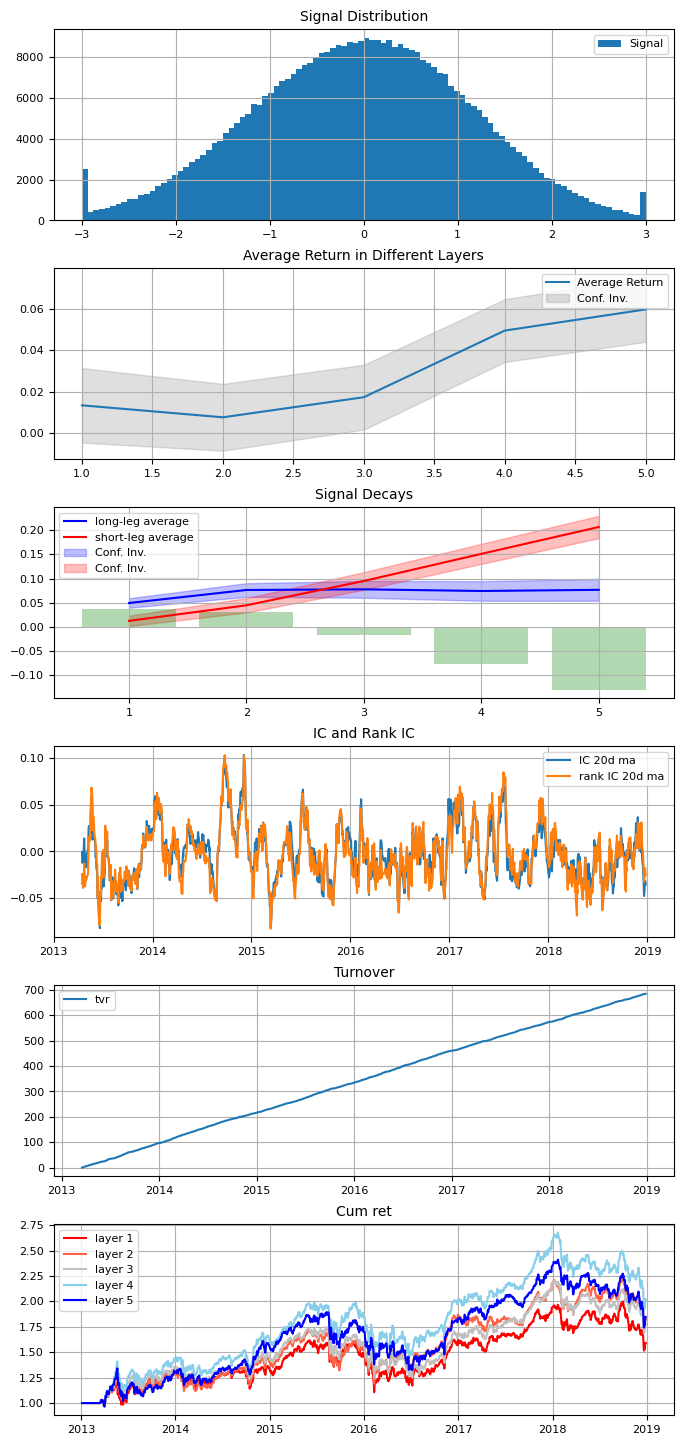

In [26]:
check_single_signal(get_mmt_normal(price, window=10, winsorization=True), price=price_in)

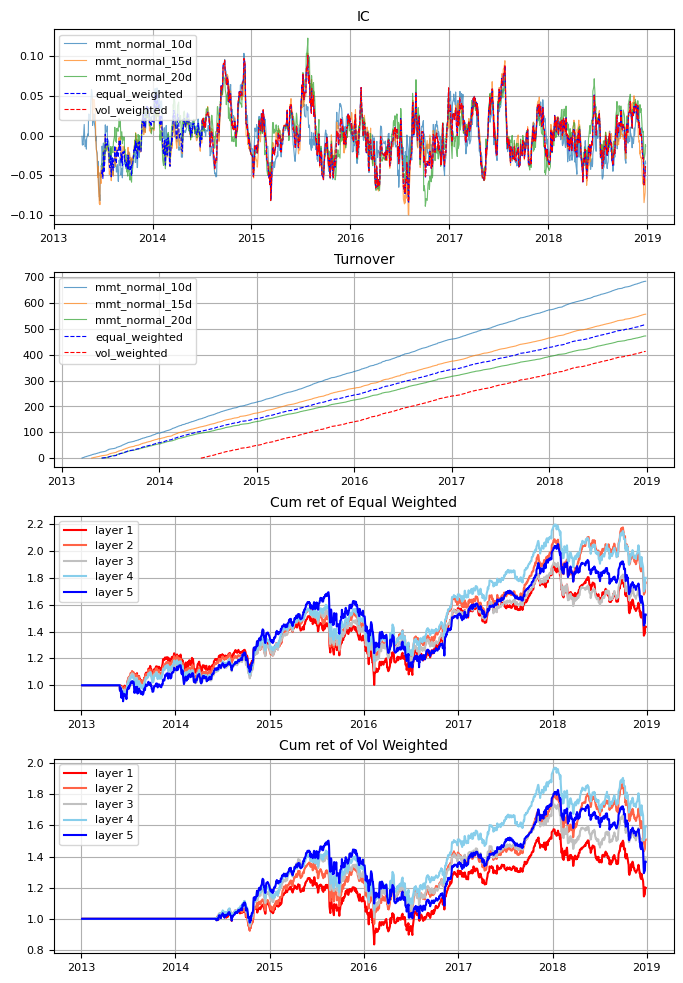

,IC,IC_IR,rank_IC,Turnover,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5
mmt_normal_10d,-0.001891,-0.514659,-0.002442,120.344172,7.905542,10.233075,9.821140,11.940924,10.453332
mmt_normal_15d,-0.000719,-0.189969,-0.001253,99.702890,6.475380,8.455934,8.978433,9.767667,8.744370
mmt_normal_20d,0.001880,0.485876,0.001390,86.181321,4.726722,7.272565,8.230147,9.724189,8.553107
equal_weighted,-0.000402,-0.103229,-0.001077,94.052343,6.138712,9.666739,7.148763,10.011032,7.192960
vol_weighted,0.001350,0.306058,0.000990,91.977124,3.069167,6.999145,5.661078,7.919688,5.306254


In [30]:
signal_list = ['mmt_normal_10d',
               'mmt_normal_15d',
               'mmt_normal_20d']
res_data = check_multi_signals(signal_list, price=price_in, Signals=Signals)
summary_evaluation(signal_list, res_data)

In [31]:
calc_ic_correlation(res_data)

,mmt_normal_10d,mmt_normal_15d,mmt_normal_20d,equal_weighted,vol_weighted
mmt_normal_10d,1.000000,0.769363,0.615131,0.860239,0.862194
mmt_normal_15d,0.769363,1.000000,0.851591,0.960154,0.959814
mmt_normal_20d,0.615131,0.851591,1.000000,0.907896,0.906413
equal_weighted,0.860239,0.960154,0.907896,1.000000,0.999962
vol_weighted,0.862194,0.959814,0.906413,0.999962,1.000000


#### Average Momentum
$mmt_t(m,n) = 1/m\sum_{i=t-m}^{t-1} P_i-1/n\sum_{i=t-n}^{t-1} P_i,  (m<n)$

In [32]:
def get_mmt_average(price_df, window, winsorization=True):

    raw_signal = price_df.rolling(window[0]).mean() / price_df.rolling(window[1]).mean()
    standard_signal = rolling_z_score(raw_signal, window[1]*4)

    if winsorization:
        # Here we treat signal with absolute value over 2.5 as outliers
        standard_signal_winsorized = winsorize(standard_signal, 3)
        return standard_signal_winsorized
    else:
        return standard_signal

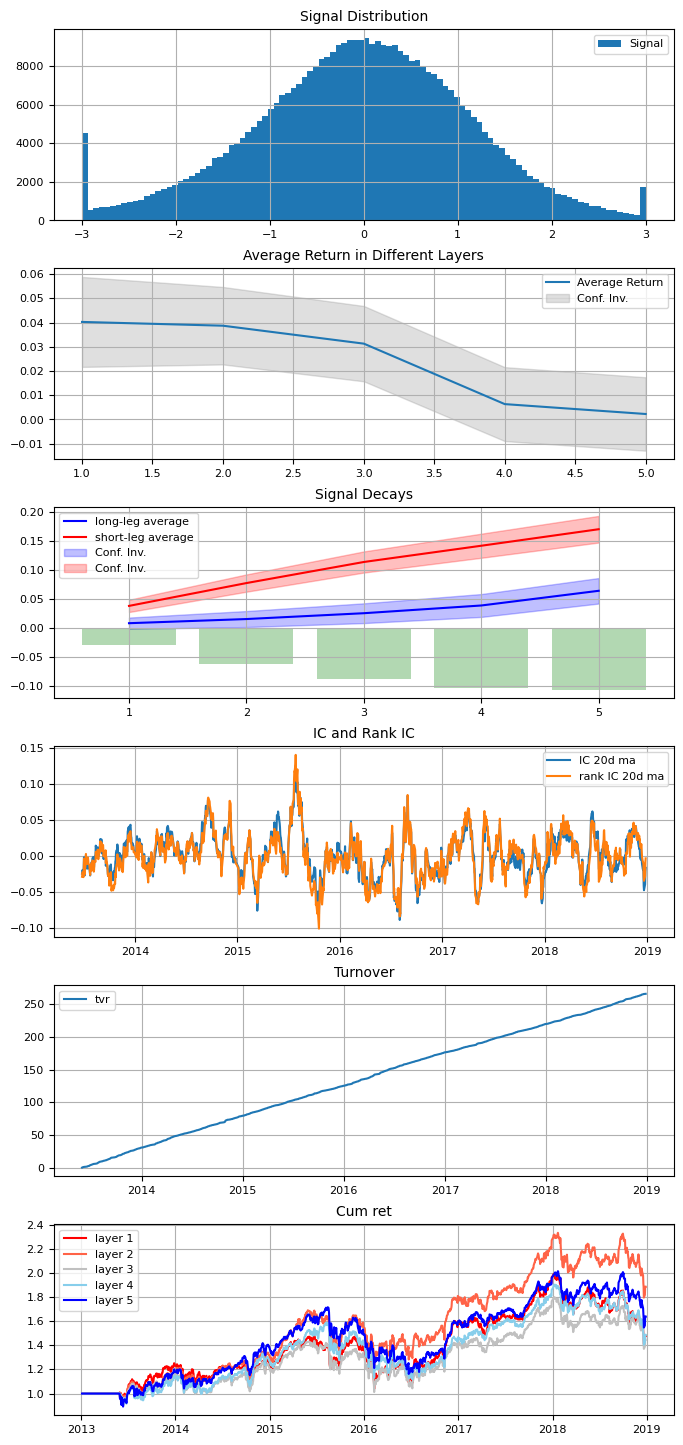

In [33]:
check_single_signal(get_mmt_average(price, window=(10,20), winsorization=True), price=price_in)

#### Discrete Momentum
$mmt_t(k) = 1/k \sum_{i=t-k}^{t} 1_{r_i>0}$

In [34]:
def get_mmt_discrete(price_df, window, winsorization=True):

    raw_signal = (price_df.diff(1)>0).rolling(window).mean() / window
    standard_signal = rolling_z_score(raw_signal, window*4)

    if winsorization:
        # Here we treat signal with absolute value over 2.5 as outliers
        standard_signal_winsorized = winsorize(standard_signal, 3)
        return standard_signal_winsorized
    else:
        return standard_signal

In [35]:
Signals['mmt_discrete_10d'] = -get_mmt_discrete(price, window=10, winsorization=True)
Signals['mmt_discrete_15d'] = -get_mmt_discrete(price, window=15, winsorization=True)
Signals['mmt_discrete_20d'] = -get_mmt_discrete(price, window=20, winsorization=True)

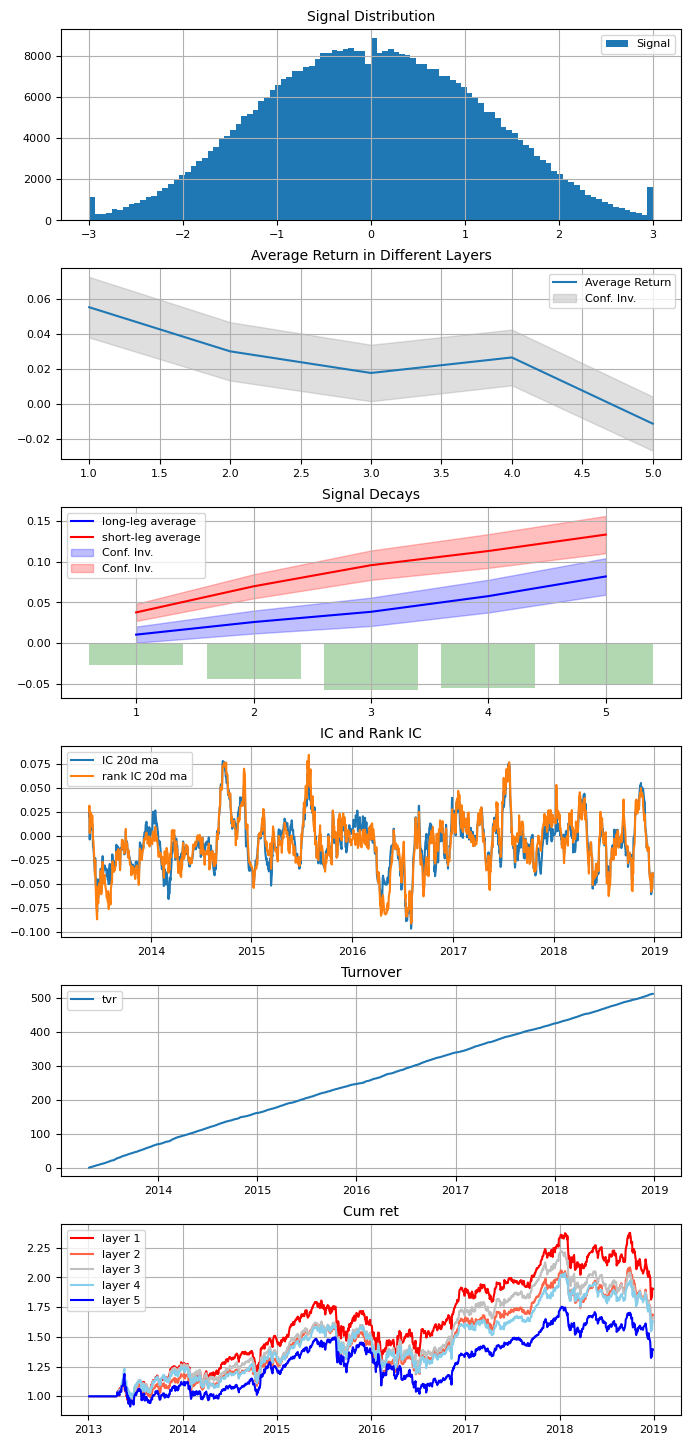

In [36]:
check_single_signal(get_mmt_discrete(price, window=15, winsorization=True), price=price_in)

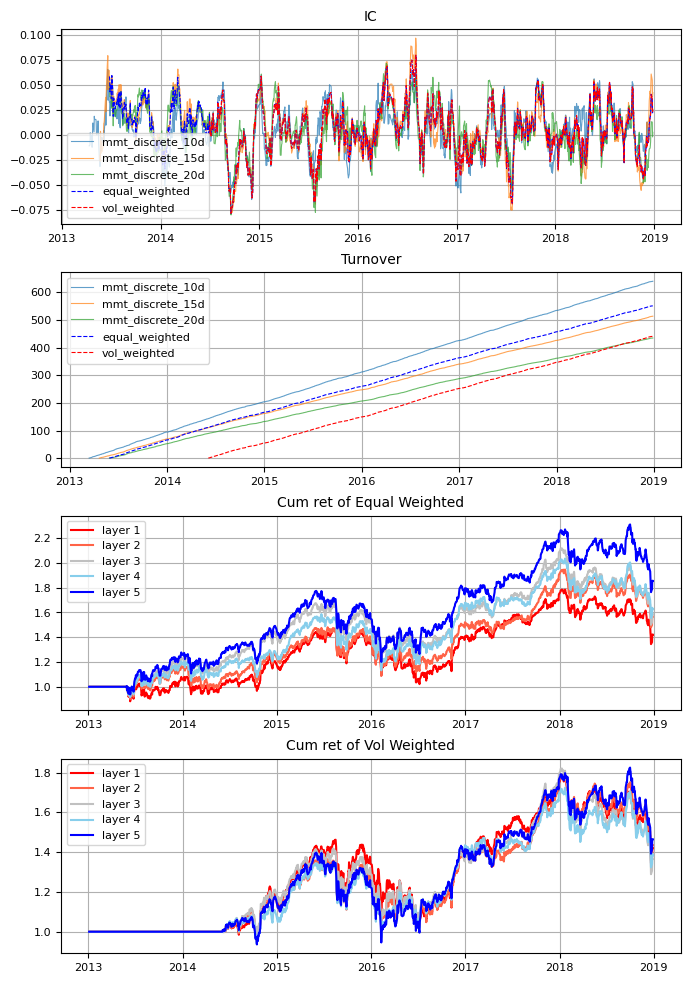

,IC,IC_IR,rank_IC,Turnover,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5
mmt_discrete_10d,0.005461,1.824108,0.005851,112.503892,7.914414,10.042288,9.952485,9.867736,10.271979
mmt_discrete_15d,0.006877,2.241726,0.007006,91.911894,5.638586,8.313175,8.649099,8.868725,10.952118
mmt_discrete_20d,0.005830,1.882063,0.004368,79.203171,6.267136,7.990498,7.605876,8.049216,10.047539
equal_weighted,0.006804,2.184782,0.006342,100.430432,5.961882,7.637257,7.855480,8.268805,10.509090
vol_weighted,0.003736,1.049917,0.002166,98.150728,5.963752,6.153271,5.303017,5.514307,6.489464


In [37]:
signal_list = ['mmt_discrete_10d',
               'mmt_discrete_15d',
               'mmt_discrete_20d']
res_data = check_multi_signals(signal_list, price=price_in, Signals=Signals)
summary_evaluation(signal_list, res_data)

In [41]:
calc_ic_correlation(res_data)

,mmt_discrete_10d,mmt_discrete_15d,mmt_discrete_20d,equal_weighted,vol_weighted
mmt_discrete_10d,1.000000,0.762095,0.597797,0.862617,0.865571
mmt_discrete_15d,0.762095,1.000000,0.833596,0.954864,0.954450
mmt_discrete_20d,0.597797,0.833596,1.000000,0.898559,0.896102
equal_weighted,0.862617,0.954864,0.898559,1.000000,0.999968
vol_weighted,0.865571,0.954450,0.896102,0.999968,1.000000


### Volatility

#### Max-min Volatility
$vol_t(k) =(max_{i\in(t-k,t)}[P_i] - min_{i\in(t-k,t)}[P_i]) / (max_{i\in(t-k,t)}[P_i] + min_{i\in(t-k,t)}[P_i])$

In [42]:
def get_vol_maxmin(price_df, window, winsorization=True):
    pmax = price_df.rolling(window).max()
    pmin = price_df.rolling(window).min()
    raw_signal = (pmax - pmin) / (pmax + pmin)
    standard_signal = rolling_z_score(raw_signal, window*4)

    if winsorization:
        # Here we treat signal with absolute value over 2.5 as outliers
        standard_signal_winsorized = winsorize(standard_signal, 3)
        return standard_signal_winsorized
    else:
        return standard_signal

In [43]:
Signals['vol_maxmin_15d'] = -get_vol_maxmin(price, window=15, winsorization=True)
Signals['vol_maxmin_20d'] = -get_vol_maxmin(price, window=20, winsorization=True)

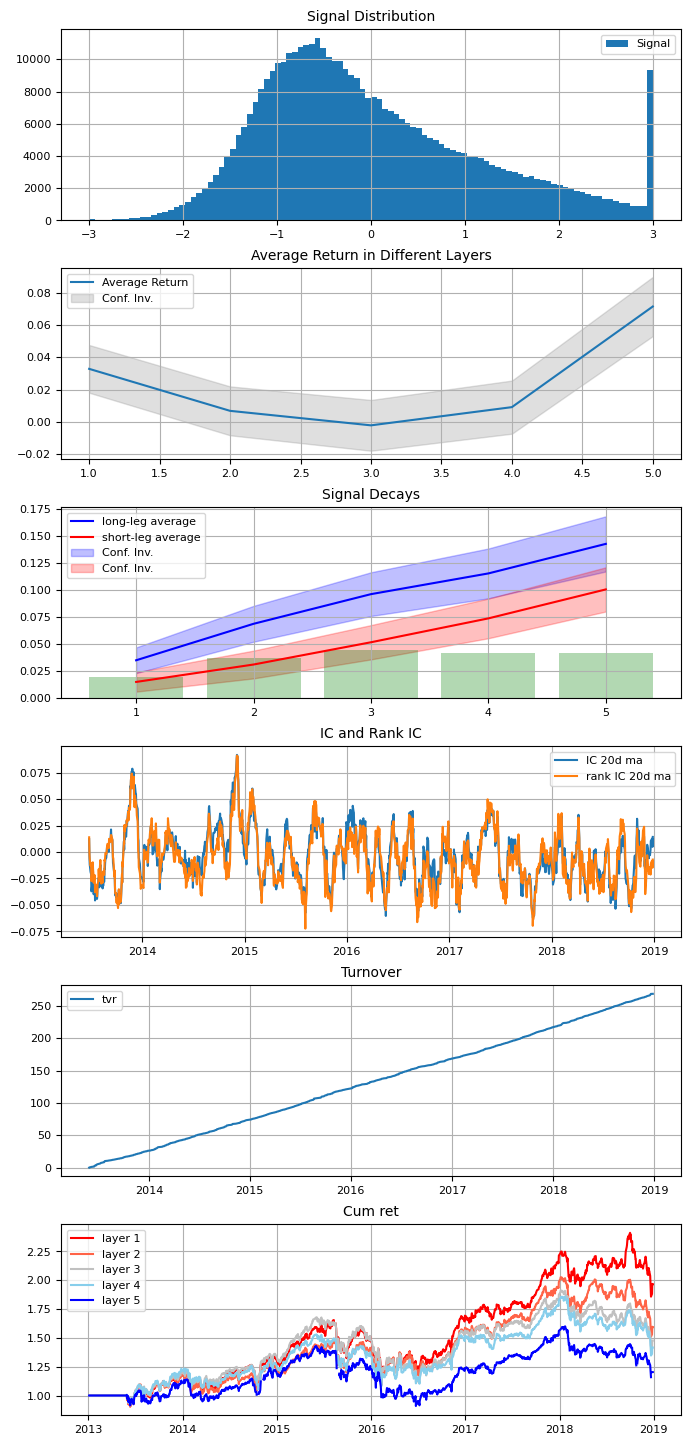

In [44]:
check_single_signal(get_vol_maxmin(price, window=20, winsorization=True), price=price_in)

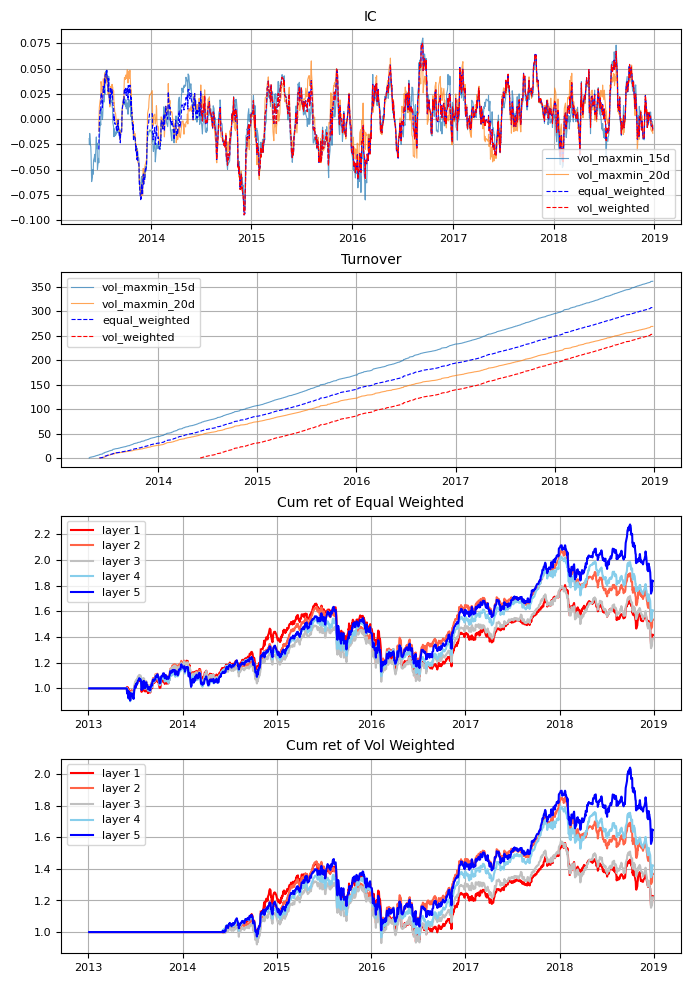

,IC,IC_IR,rank_IC,Turnover,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5
vol_maxmin_15d,0.001193,0.387644,0.002247,64.601388,5.965173,4.185818,7.953704,8.771803,9.009222
vol_maxmin_20d,0.003476,1.150662,0.005614,48.988180,3.197375,5.938398,6.639181,7.919615,11.494516
equal_weighted,0.002534,0.823157,0.004439,56.017559,5.978325,7.309528,5.581308,8.067039,10.333278
vol_weighted,0.003809,1.101136,0.006116,56.278003,3.510386,5.343884,3.389463,5.979162,8.477351


In [45]:
signal_list = ['vol_maxmin_15d',
               'vol_maxmin_20d']
res_data = check_multi_signals(signal_list, price=price_in, Signals=Signals)
summary_evaluation(signal_list, res_data)

In [55]:
calc_ic_correlation(res_data)

,vol_maxmin_15d,vol_maxmin_20d,equal_weighted,vol_weighted
vol_maxmin_15d,1.000000,0.767046,0.939825,0.940221
vol_maxmin_20d,0.767046,1.000000,0.938370,0.937903
equal_weighted,0.939825,0.938370,1.000000,0.999974
vol_weighted,0.940221,0.937903,0.999974,1.000000


# Porfolio and back-testing

## Portfolio construction

### Signal pool selection

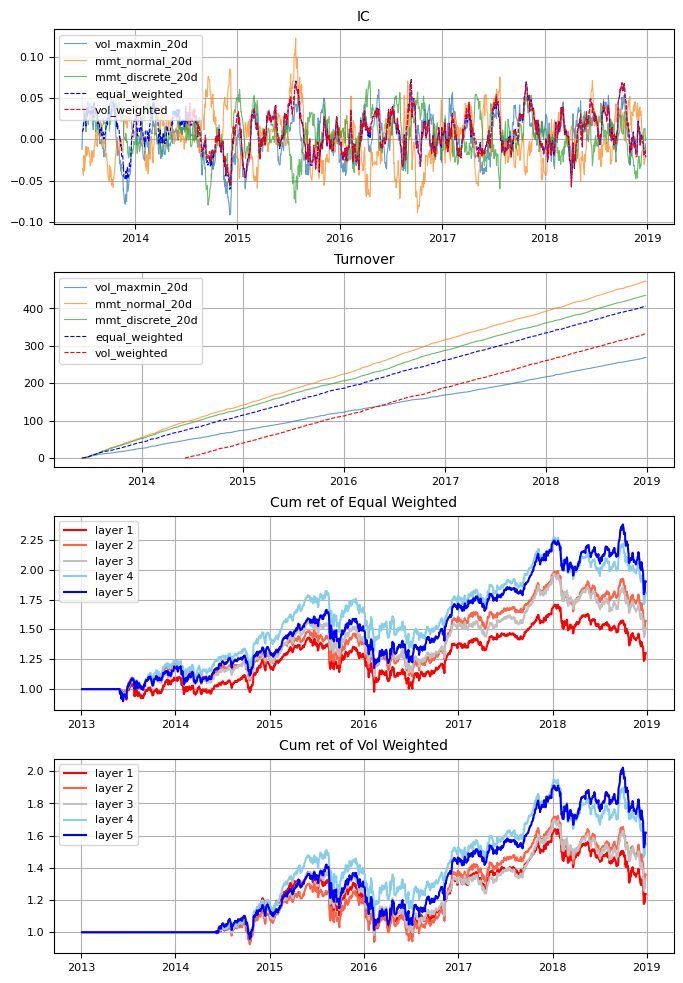

,IC,IC_IR,rank_IC,Turnover,Layer 1,Layer 2,Layer 3,Layer 4,Layer 5
vol_maxmin_20d,0.003476,1.150662,0.005614,48.988180,3.197375,5.938398,6.639181,7.919615,11.494516
mmt_normal_20d,0.001880,0.485876,0.001390,86.181321,4.726722,7.272565,8.230147,9.724189,8.553107
mmt_discrete_20d,0.005830,1.882063,0.004368,79.203171,6.267136,7.990498,7.605876,8.049216,10.047539
equal_weighted,0.008295,3.023280,0.008378,74.092302,4.463240,7.679342,7.050203,10.059111,10.922103
vol_weighted,0.007680,2.467778,0.007513,73.959327,3.604227,5.193962,4.827430,7.441249,8.180613


In [60]:
signal_pool = ['vol_maxmin_20d',
               'mmt_normal_20d',
               'mmt_discrete_20d']
res_data = check_multi_signals(signal_pool, price=price_in, Signals=Signals)
summary_evaluation(signal_pool, res_data)

In [61]:
calc_ic_correlation(res_data)

,vol_maxmin_20d,mmt_normal_20d,mmt_discrete_20d,equal_weighted,vol_weighted
vol_maxmin_20d,1.000000,-0.117200,0.147771,0.823222,0.820754
mmt_normal_20d,-0.117200,1.000000,-0.835575,0.147573,0.153241
mmt_discrete_20d,0.147771,-0.835575,1.000000,0.181588,0.174787
equal_weighted,0.823222,0.147573,0.181588,1.000000,0.996875
vol_weighted,0.820754,0.153241,0.174787,0.996875,1.000000


### Position Generation
I use two kind of strategies using the signel pool:
- Regression based weight signals
- Equal weight signals

#### Regression base weight signals

In [282]:
Ret = price.pct_change(1).shift(-1)
window = 500
params = []
timestamp = []
for i in range(0,len(price.index)-window):
    data = {}
    for sgn in signal_pool:
        x = Signals[sgn].iloc[i:i+window]
        data[sgn] = np.ravel(x)
    data['ret'] = np.ravel(-Ret.iloc[i:i+window])

    data_df = pd.DataFrame(data)
    data_df.dropna(inplace=True)

    Xs = data_df[signal_pool]
    Xs = sm.add_constant(Xs)
    y = data_df[['ret']] * 100
    params.append(np.linalg.lstsq(Xs, y)[0])
    timestamp.append(Signals[sgn].index[i+window-1])

In [283]:
params_df = [(p.T)[0] for p in params]
params_df = [(p.T)[0] for p in params]
params_df = pd.DataFrame(params_df)
params_df.columns = ['const'] + signal_pool
params_df.index = timestamp
params_df = params_df.reindex(Ret.index)
params_df = params_df.shift(1)

comb = 0
for sgn in signal_pool:
    comb += Signals[sgn].multiply(params_df[sgn], axis=0)
comb = comb.add(params_df['const'], axis='index')

In [284]:
comb_demean = comb.sub(comb.mean(axis=1), axis='index')
strategy_regress = comb_demean.div(abs(comb_demean).sum(axis=1), axis='index')

#### Equally weight signals

In [286]:
comb_equal = 0
for sgn in signal_pool:
    comb_equal += Signals[sgn] / len(signal_pool)

In [287]:
comb_equal_demean = comb_equal.sub(comb_equal.mean(axis=1), axis='index')
strategy_equal = comb_equal_demean.div(abs(comb_equal_demean).sum(axis=1), axis='index')

### Back-testing

#### PNL evaluation

In [311]:
def annual_return(series):
    series.dropna(inplace=True)
    return (series[-1]/series[0])**(365/(series.index[-1]-series.index[0]).days) - 1

def annual_earning(series):
    return (series[-1] - series[0])*(365/(series.index[-1]-series.index[0]).days)

def annual_volatility(series):
    series.dropna(inplace=True)
    return np.std(series.pct_change(1)) *  np.sqrt(255)

def annual_volatility2(series):
    series.dropna(inplace=True)
    return np.std(series.diff(1)) *  np.sqrt(255)

def drawdown(series):
    return -((np.maximum.accumulate(series)) - series) / np.maximum.accumulate(series)

def max_drawdown(series):
    series.dropna(inplace=True)
    i = np.argmax((np.maximum.accumulate(series)) - series)
    if i == series.index[0]:
        j = i
    else:
        j = np.argmax(series[:i])
    maxdrawdown_rate = (series[j] - series[i]) / series[j]
    return -maxdrawdown_rate

def max_drawdown2(series):
    series.dropna(inplace=True)
    i = np.argmax((np.maximum.accumulate(series)) - series)
    if i == series.index[0]:
        j = i
    else:
        j = np.argmax(series[:i])
    maxdrawdown = (series[j] - series[i]) 
    return -maxdrawdown

def sharpe_ratio(series):
    series.dropna(inplace=True)
    return (annual_return(series)-rf_rate) / annual_volatility(series)

def sharpe_ratio2(series):
    series.dropna(inplace=True)
    return (annual_earning(series)) / annual_volatility2(series)

def hit_rate(series):
    series.dropna(inplace=True)
    r = series.pct_change(1)
    return sum(r>0) / len(r)

def anal_res(pnl):
    funcs = {'annual return': annual_earning,
             'annual volatility': annual_volatility2,
             'max drawdown rate': max_drawdown2,
             'sharpe ratio': sharpe_ratio2,
             'hit rate': hit_rate}
    res = {}
    for k in funcs.keys():
        res[k] = [funcs[k](pnl)]
    return res



In [345]:
def pnl_evaluate(pnl):
    fig,axes = plt.subplots(2,1, figsize=(8, 6)) # Creates the Axis.
    plt.subplots_adjust(wspace=0.25,hspace=0.25)
    axes[0].plot(pnl, label='pnl')
    adjust_subplot(axes[0],'PNL')

    axes[1].plot(drawdown(pnl), label='drawdown rate')
    adjust_subplot(axes[1],'downdown')

    plt.show()

#### Back-testing

In [288]:
transaction_cost = 0.00025

def back_test(strategy, price=price, transaction_cost=transaction_cost):
    strategy = strategy.reindex(price.index)
    turnover = abs(strategy.diff(1)).sum(axis=1)
    Ret = price.pct_change(1).shift(-1)
    r = (Ret*strategy).sum(axis=1)

    pnl = pd.DataFrame()
    pnl['with_tc'] = (1+r- turnover*transaction_cost).cumprod()
    pnl['without_tc'] = (1+r).cumprod()
    return pnl

In [289]:
pnl_regress = back_test(strategy_regress, price_in)
pnl_equal = back_test(strategy_equal, price_in)

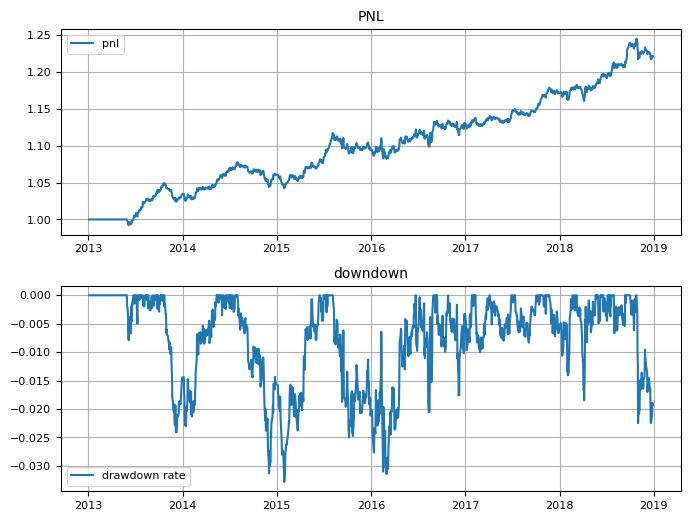

In [346]:
pnl_evaluate(pnl_equal['without_tc'])

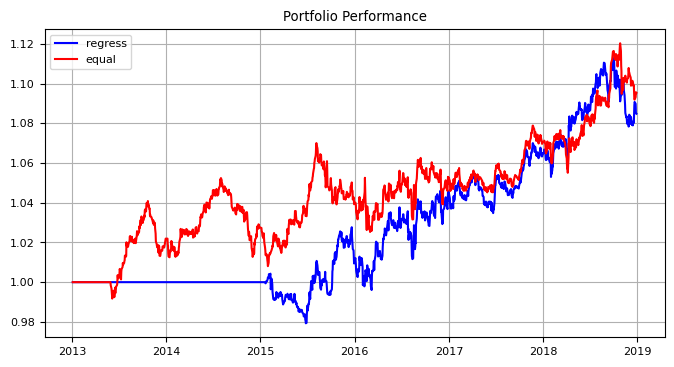

In [291]:
plt.figure(figsize=(8,4))
plt.plot(pnl_regress['with_tc'], color='blue',label='regress')
plt.plot(pnl_equal['with_tc'], color='red', label='equal')

plt.title('Portfolio Performance')
plt.legend()
plt.grid()
plt.show() 

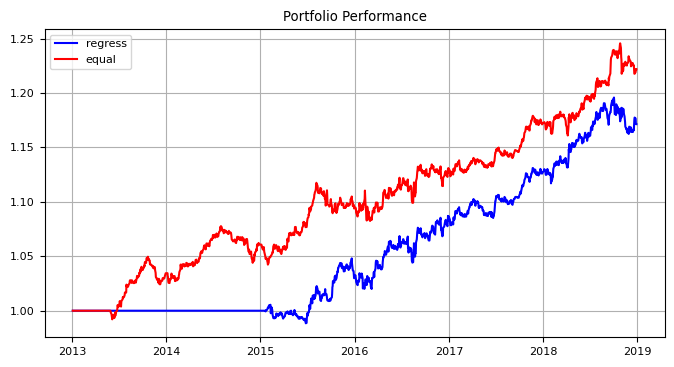

In [292]:
plt.figure(figsize=(8,4))
plt.plot(pnl_regress['without_tc'], color='blue',label='regress')
plt.plot(pnl_equal['without_tc'], color='red', label='equal')

plt.title('Portfolio Performance')
plt.legend()
plt.grid()
plt.show() 

In [324]:
summary = pd.DataFrame()
res1 = pd.DataFrame(anal_res(pnl_regress['with_tc'])); res1.index = ['regress_with_tc']
res2 = pd.DataFrame(anal_res(pnl_equal['with_tc'])); res2.index = ['equal_with_tc']
res3 = pd.DataFrame(anal_res(pnl_regress['without_tc'])); res3.index = ['regress_without_tc']
res4 = pd.DataFrame(anal_res(pnl_equal['without_tc'])); res4.index = ['equal_without_tc']
summary = pd.concat([res1, res2, res3, res4])

In [325]:
summary

,annual return,annual volatility,max drawdown rate,sharpe ratio,hit rate
regress_with_tc,0.014186,0.029901,-0.034548,0.474414,0.343537
equal_with_tc,0.015935,0.032244,-0.044793,0.494192,0.488435
regress_without_tc,0.028641,0.031203,-0.033415,0.917874,0.359864
equal_without_tc,0.037057,0.034252,-0.035370,1.081880,0.503401


# Out-of-sample Analysis

In [329]:
pnl_regress_whole = back_test(strategy_regress, price)
pnl_equal_whole = back_test(strategy_equal, price)
pnl_regress_out = pnl_regress_whole[pnl_regress_whole.index > time_point]
pnl_equal_out = pnl_equal_whole[pnl_equal_whole.index > time_point]

pnl_regress_out = pnl_regress_out / pnl_regress_out.iloc[0]
pnl_equal_out = pnl_equal_out / pnl_equal_out.iloc[0]

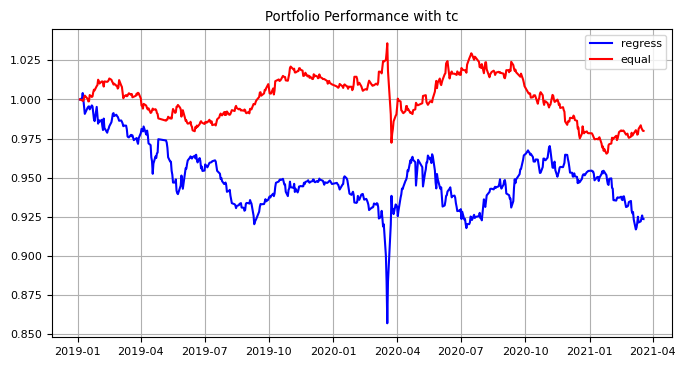

In [333]:
plt.figure(figsize=(8,4))
plt.plot(pnl_regress_out['with_tc'], color='blue',label='regress')
plt.plot(pnl_equal_out['with_tc'], color='red', label='equal')

plt.title('Portfolio Performance with tc')
plt.legend()
plt.grid()
plt.show() 

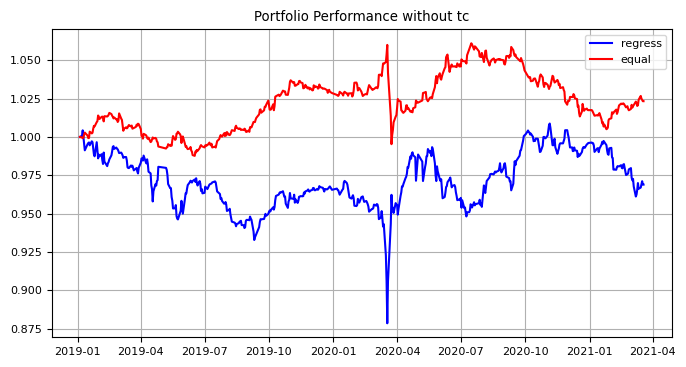

In [332]:
plt.figure(figsize=(8,4))
plt.plot(pnl_regress_out['without_tc'], color='blue',label='regress')
plt.plot(pnl_equal_out['without_tc'], color='red', label='equal')

plt.title('Portfolio Performance without tc')
plt.legend()
plt.grid()
plt.show() 

In [334]:
summary = pd.DataFrame()
res1 = pd.DataFrame(anal_res(pnl_regress_out['with_tc'])); res1.index = ['regress_with_tc']
res2 = pd.DataFrame(anal_res(pnl_equal_out['with_tc'])); res2.index = ['equal_with_tc']
res3 = pd.DataFrame(anal_res(pnl_regress_out['without_tc'])); res3.index = ['regress_without_tc']
res4 = pd.DataFrame(anal_res(pnl_equal_out['without_tc'])); res4.index = ['equal_without_tc']
summary = pd.concat([res1, res2, res3, res4])

In [335]:
summary

,annual return,annual volatility,max drawdown rate,sharpe ratio,hit rate
regress_with_tc,-0.034651,0.065396,-0.147107,-0.529865,0.502804
equal_with_tc,-0.009109,0.042363,-0.070534,-0.215022,0.506542
regress_without_tc,-0.014078,0.066981,-0.125736,-0.210180,0.517757
equal_without_tc,0.010571,0.043365,-0.064684,0.243760,0.532710
